In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        # Simple neural network with one hidden layer
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128) # Input layer to hidden layer
        self.fc2 = nn.Linear(128, env.action_space.n) # Hidden layer to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Activation function for hidden layer
        x = self.fc2(x)
        return torch.softmax(x, dim=-1) # Output layer with softmax to get action probabilities


In [4]:
policy_net = PolicyNetwork()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-2) # Use Adam optimizer

In [5]:
# Function to choose an action based on policy network's output
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0) # Convert state to tensor
    probs = policy_net(state) # Get action probabilities from policy network
    m = Categorical(probs) # Create a categorical distribution to sample action
    action = m.sample() # Sample an action
    return action.item(), m.log_prob(action) # Return the chosen action and log probability of the action


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last reward: 13.00
Episode 1	Last reward: 15.00
Episode 2	Last reward: 14.00
Episode 3	Last reward: 13.00
Episode 4	Last reward: 13.00
Episode 5	Last reward: 8.00
Episode 6	Last reward: 14.00
Episode 7	Last reward: 11.00
Episode 8	Last reward: 9.00
Episode 9	Last reward: 10.00
Episode 10	Last reward: 11.00
Episode 11	Last reward: 10.00
Episode 12	Last reward: 10.00
Episode 13	Last reward: 8.00
Episode 14	Last reward: 8.00
Episode 15	Last reward: 10.00
Episode 16	Last reward: 10.00
Episode 17	Last reward: 8.00
Episode 18	Last reward: 10.00
Episode 19	Last reward: 8.00
Episode 20	Last reward: 9.00
Episode 21	Last reward: 8.00
Episode 22	Last reward: 9.00
Episode 23	Last reward: 9.00
Episode 24	Last reward: 8.00
Episode 25	Last reward: 10.00
Episode 26	Last reward: 11.00
Episode 27	Last reward: 9.00
Episode 28	Last reward: 11.00
Episode 29	Last reward: 9.00
Episode 30	Last reward: 10.00
Episode 31	Last reward: 10.00
Episode 32	Last reward: 8.00
Episode 33	Last reward: 9.00
Episo

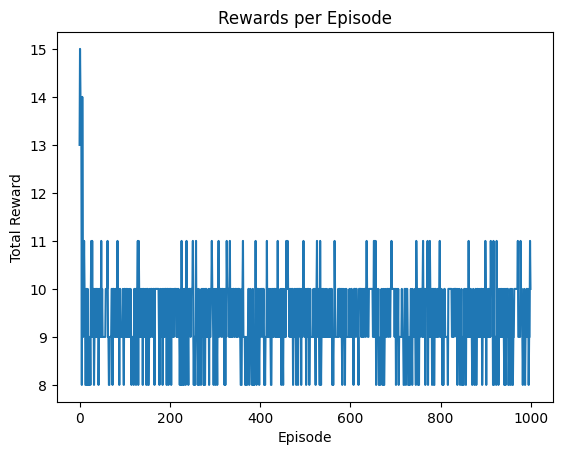

In [6]:
# Training loop with visualization
def train_policy_with_visualization():
    episode_rewards = [] # List to store rewards for each episode
    for episode in range(1000): # Train for 1000 episodes
        state, ep_reward = env.reset(), 0
        while True: # Run until the episode is done
            action, log_prob = select_action(state) # Select an action
            state, reward, done, _ = env.step(action) # Take the action in the environment
            ep_reward += reward
            optimizer.zero_grad()
            loss = -log_prob * reward # Calculate loss
            loss.backward() # Backpropagate the loss
            optimizer.step() # Update policy network weights
            if done:
                break
        episode_rewards.append(ep_reward) # Store episode reward
        print('Episode {}\tLast reward: {:.2f}'.format(episode, ep_reward))

    # Plot the rewards
    plt.plot(episode_rewards)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

# Call the modified training function to start training with visualization
train_policy_with_visualization()

## This code is a very basic implementation and serves as a conceptual introduction. Real-world PPO implementations involve more complexities such as advantage estimation, multiple epochs over the same set of experiences, and clipping in the objective function to improve stability and performance.

In [7]:
# Define the Actor-Critic neural network architecture
class ActorCritic(nn.Module):  # Define a neural network class inheriting from nn.Module
    def __init__(self, input_dim, action_dim, hidden_dim=256):  # Initialize the class constructor
        super(ActorCritic, self).__init__()  # Call the superclass constructor
        # Define the actor network architecture
        self.actor = nn.Sequential(  # Define a sequence of neural network layers
            nn.Linear(input_dim, hidden_dim),  # Linear layer mapping input to hidden dimensions
            nn.ReLU(),  # ReLU activation function
            nn.Linear(hidden_dim, action_dim),  # Linear layer mapping hidden to action dimensions
            nn.Softmax(dim=-1),  # Softmax activation function to get action probabilities
        )
        # Define the critic network architecture
        self.critic = nn.Sequential(  # Define a sequence of neural network layers
            nn.Linear(input_dim, hidden_dim),  # Linear layer mapping input to hidden dimensions
            nn.ReLU(),  # ReLU activation function
            nn.Linear(hidden_dim, 1)  # Linear layer mapping hidden to a single output (state value)
        )

    def forward(self, x):  # Define the forward pass method
        # Forward pass through both actor and critic networks
        action_prob = self.actor(x)  # Calculate action probabilities
        value = self.critic(x)  # Estimate state values
        return action_prob, value  # Return action probabilities and state values

In [8]:
# Function to compute Generalized Advantage Estimation (GAE)
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    # Initialize variables
    values = values + [next_value]  # Append the next value to the list of values
    gae = 0  # Initialize Generalized Advantage Estimation (GAE)
    returns = []  # Initialize list to store returns
    # Compute returns and advantages using GAE
    for step in reversed(range(len(rewards))):  # Iterate over time steps in reverse order
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]  # Compute delta
        gae = delta + gamma * tau * masks[step] * gae  # Update GAE
        returns.insert(0, gae + values[step])  # Insert the computed return
    return returns  # Return the list of computed returns

In [9]:
# Function to perform Proximal Policy Optimization (PPO) update step
def ppo_update(policy, optimizer, states, actions, log_probs, returns, advantages, clip_param=0.2):
    # Forward pass to get action probabilities and state values
    action_probs, state_values = policy(states)
    dist = Categorical(action_probs)  # Create a Categorical distribution
    new_log_probs = dist.log_prob(actions)  # Compute log probabilities of actions

    # Compute PPO loss
    ratio = torch.exp(new_log_probs - log_probs)  # Compute ratio of new and old probabilities
    surr1 = ratio * advantages  # Compute surrogate 1
    surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantages  # Compute surrogate 2
    policy_loss = -torch.min(surr1, surr2).mean()  # Compute policy loss
    value_loss = (returns - state_values).pow(2).mean()  # Compute value loss

    # Compute combined loss and perform optimization step
    optimizer.zero_grad()  # Zero the gradients
    (policy_loss + 0.5 * value_loss).backward()  # Backpropagate the total loss
    optimizer.step()  # Update the model parameters

In [10]:
# Function to train the PPO agent
def train(env_name, num_steps=1000, batch_size=64):
    env = gym.make(env_name)  # Create the Gym environment
    input_dim = env.observation_space.shape[0]  # Get the input dimension
    action_dim = env.action_space.n  # Get the action dimension
    policy = ActorCritic(input_dim, action_dim)  # Initialize the policy network
    optimizer = optim.Adam(policy.parameters(), lr=3e-4)  # Initialize Adam optimizer

    # Initialize lists to store training data
    state = env.reset()  # Reset the environment and get initial state
    log_probs = []  # List to store log probabilities of actions
    values = []  # List to store state values
    states = []  # List to store states
    actions = []  # List to store actions
    rewards = []  # List to store rewards
    masks = []  # List to store masks indicating episode termination
    for step in range(num_steps):  # Iterate over training steps
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor
        action_prob, value = policy(state)  # Get action probabilities and state value

        dist = Categorical(action_prob)  # Create a Categorical distribution
        action = dist.sample()  # Sample an action from the distribution
        next_state, reward, done, _ = env.step(action.item())  # Take a step in the environment

        log_prob = dist.log_prob(action)  # Compute log probability of the action
        log_probs.append(log_prob)  # Append log probability to the list
        values.append(value)  # Append state value to the list
        rewards.append(reward)  # Append reward to the list
        masks.append(1 - float(done))  # Append mask indicating episode termination
        states.append(state)  # Append state to the list
        actions.append(action)  # Append action to the list

        state = next_state  # Update the current state
        if done:  # If episode is done
            state = env.reset()  # Reset the environment
        if step % batch_size == 0 and step > 0:  # If it's time to update the policy
            next_state = torch.FloatTensor(next_state).unsqueeze(0)  # Convert next state to tensor
            _, next_value = policy(next_state)  # Get next state value
            returns = compute_gae(next_value, rewards, masks, values)  # Compute GAE returns

            # Concatenate and detach tensors
            returns = torch.cat(returns).detach()  # Concatenate and detach returns
            log_probs = torch.cat(log_probs).detach()  # Concatenate and detach log probabilities
            values = torch.cat(values).detach()  # Concatenate and detach state values
            states = torch.cat(states)  # Concatenate states
            actions = torch.cat(actions)  # Concatenate actions
            advantages = returns - values  # Compute advantages

            # Perform PPO update step
            ppo_update(policy, optimizer, states, actions, log_probs, returns, advantages)

            # Clear lists for next batch
            log_probs = []  # Clear log probabilities list
            values = []  # Clear state values list
            states = []  # Clear states list
            actions = []  # Clear actions list
            rewards = []  # Clear rewards list
            masks = []  # Clear masks list

# Train the PPO agent on the CartPole environment
train('CartPole-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## I hope the comments in the code helps you out.

<p align="center"><font size = ""><b> -- End of program -- </b><font></p>
<p align="center"><font size = "10"><b> Happy coding! ☺ </b><font></p>